In [9]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)

import warnings

%matplotlib inline

pd.options.display.max_columns = 80

In [5]:
trips = pd.read_csv('/home/data/fall_2018/HWtrips_032319.csv')

In [7]:
TOD_bounds = (trips.loc[:, ["TOD", "HW_trip_ET"]]
  .groupby("TOD")
  .agg(['min', 'max'])
  #.reset_index(inplace=True)
)
TOD_bounds.columns = TOD_bounds.columns.map('_'.join).str.strip(" _")
#TOD_bounds = TOD_bounds.rename(columns={"TOD_": "TOD"})
TOD_bounds

dwell_bounds = (trips.loc[:, ["dwell_work", "work_dwell"]]
  .groupby("dwell_work")
  .agg(['min', 'max'])
  #.reset_index(inplace=True)
)
dwell_bounds.columns = dwell_bounds.columns.map('_'.join).str.strip(" _")
#dwell_bounds = dwell_bounds.rename(columns={"TOD_": "TOD"})
dwell_bounds


,work_dwell_min,work_dwell_max
dwell_work,,
1,0.016667,4.500000
2,4.500000,7.750000
3,7.750000,9.000000
4,9.000000,10.483333
5,10.500000,19.500000


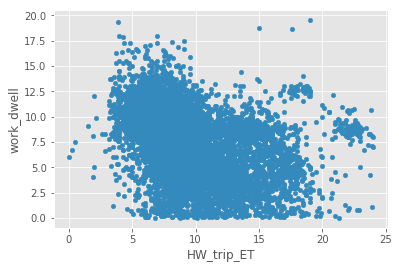

In [8]:
trips.plot.scatter(x='HW_trip_ET',
                   y='work_dwell')

In [16]:
f"Correlation between End Time and Dwell Time: {trips['HW_trip_ET'].corr(trips['work_dwell'])}"


## Given the correlation between HW_trip_ET and work_dwell time
## maybe it makes sense to draw them jointly from a multivariate distribution?

'Correlation between End Time and Dwell Time: -0.4067233807085886'

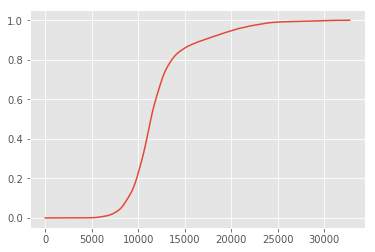

In [20]:
#import dfply as dp
#from dfply import >>
import statsmodels.api as sm

dens = sm.nonparametric.KDEUnivariate(trips["HW_trip_ET"])
dens.fit()
plt.plot(dens.cdf)
plt.show()


In [6]:

def ST_guassian_kde(group):
    data = group[["HW_trip_ST", "WH_trip_ST"]].values.T
    return stats.gaussian_kde(data)

ST_kde = (trips.loc[:, ["TOD", "HW_trip_ST", "WH_trip_ST"]]
  .groupby("TOD")
  .apply(lambda x: pd.Series({"kde": ST_guassian_kde(x)}))        
  #.apply(ST_guassian_kde)
  #.reset_index(name='kde')
)

ST_kde = ST_kde.join(bounds, on=["TOD"], lsuffix="suck")
#bounds.columns, ST_kde.columns
ST_kde
# Save ST_kde DataFrame for use in simulation


,kde,HW_trip_ST_min,HW_trip_ST_max,WH_trip_ST_min,WH_trip_ST_max
TOD,,,,,
2.0,<scipy.stats.kde.gaussian_kde object at 0x7f1f...,3.016667,5.916667,9.200000,15.333333
3.0,<scipy.stats.kde.gaussian_kde object at 0x7f1f...,3.016667,5.966667,15.500000,18.450000
12.0,<scipy.stats.kde.gaussian_kde object at 0x7f1f...,6.000000,8.966667,9.000000,15.483333
13.0,<scipy.stats.kde.gaussian_kde object at 0x7f1f...,6.000000,8.966667,15.500000,18.483333
14.0,<scipy.stats.kde.gaussian_kde object at 0x7f1f...,6.000000,8.966667,0.016667,24.000000
22.0,<scipy.stats.kde.gaussian_kde object at 0x7f1f...,9.000000,14.666667,9.416667,15.483333
23.0,<scipy.stats.kde.gaussian_kde object at 0x7f1f...,9.000000,15.333333,15.500000,18.483333
24.0,<scipy.stats.kde.gaussian_kde object at 0x7f1f...,9.000000,15.416667,0.033333,24.000000


In [7]:
#from urbansim_templates import modelmanager
#modelmanager.initialize()

#modelmanager.register(m)

In [8]:
#ST_kde.loc[1, 'kde'].resample(2)
# In Simulation
n_by_TOD = (trips.groupby("TOD")
  .size()
  .reset_index(name='ntrips')
)

n_by_TOD = n_by_TOD.join(ST_kde, on="TOD")
         
n_by_TOD["ST"] = n_by_TOD.apply(lambda row: row['kde'].resample(row['ntrips']), axis=1)

n_by_TOD["HW_trip_ST"] = n_by_TOD["ST"].apply(lambda x: x[0, ])
n_by_TOD["WH_trip_ST"] = n_by_TOD["ST"].apply(lambda x: x[1, ])
#ST_kde.kde.apply(lambda x: x.resample(2))

trips_sim = pd.DataFrame({'TOD':n_by_TOD.TOD.repeat(n_by_TOD.HW_trip_ST.str.len()),
              'HW_trip_ST':np.concatenate(n_by_TOD.HW_trip_ST.values),
              'WH_trip_ST':np.concatenate(n_by_TOD.WH_trip_ST.values),
             })

#trips_sim = trips_sim.set_index("TOD")
#n_by_TOD.ST.values[0, ][0, ].shape
#n_by_TOD["HW_trip_ST"].apply(lambda x: x.shape)

# handle 24+ hour
trips_sim.loc[trips_sim["TOD"].isin([14.0, 24.0]) & (trips_sim.WH_trip_ST < 12), 'WH_trip_ST'] -= 24

In [9]:
def simulate(n_by_TOD, ST_kde):
    n_by_TOD = n_by_TOD.join(ST_kde, on="TOD")
         
    n_by_TOD["ST"] = n_by_TOD.apply(lambda row: row['kde'].resample(row['ntrips']), axis=1)

    n_by_TOD["HW_trip_ST"] = n_by_TOD["ST"].apply(lambda x: x[0, ])
    n_by_TOD["WH_trip_ST"] = n_by_TOD["ST"].apply(lambda x: x[1, ])
    #ST_kde.kde.apply(lambda x: x.resample(2))

    samples = pd.DataFrame({'TOD':n_by_TOD.TOD.repeat(n_by_TOD.HW_trip_ST.str.len()),
                  'HW_trip_ST':np.concatenate(n_by_TOD.HW_trip_ST.values),
                  'WH_trip_ST':np.concatenate(n_by_TOD.WH_trip_ST.values),
                 })
    samples = samples.reset_index()
    #print(samples.index)

    #trips_sim = trips_sim.set_index("TOD")
    #n_by_TOD.ST.values[0, ][0, ].shape
    #n_by_TOD["HW_trip_ST"].apply(lambda x: x.shape)

    # handle 24+ hour
    samples.loc[samples["TOD"].isin([14.0, 24.0]) & (samples.WH_trip_ST < 12), 'WH_trip_ST'] -= 24
    
    samples_w_bounds = samples.join(ST_kde, how="left", on="TOD")
    samples_w_bounds.reset_index()
    
    samples_good = (samples_w_bounds.query('(HW_trip_ST_min <= HW_trip_ST <= HW_trip_ST_max) and ' +
                                           '(WH_trip_ST_min <= WH_trip_ST <= WH_trip_ST_max )')
                                    .loc[:, ["TOD", "HW_trip_ST", "WH_trip_ST"]]
                   )
                         
    _n_by_TOD = (samples.loc[~samples.index.isin(samples_good.index)]
                        .groupby("TOD")
                        .size()
                        .reset_index(name='ntrips'))
    
    #print(samples.index)
    #print(samples_good.index)
    print("There are {} samples with out of bounds ST".format(_n_by_TOD.ntrips.sum()))
    if _n_by_TOD.shape[0] > 0:
        
        samples_extra = simulate(_n_by_TOD, ST_kde)
        
        samples = pd.concat([samples_good, samples_extra], sort=False)
            
            
    return samples

In [10]:
n_by_TOD = (trips.groupby("TOD")
  .size()
  .reset_index(name='ntrips')
)

n_by_TOD.columns, ST_kde.columns
trips_sim = simulate(n_by_TOD, ST_kde)
trips_sim.loc[trips_sim["TOD"].isin([14.0, 24.0]) & (trips_sim.WH_trip_ST < 12), 'WH_trip_ST'] -= 24

There are 596 samples with out of bounds ST
There are 92 samples with out of bounds ST
There are 15 samples with out of bounds ST
There are 5 samples with out of bounds ST
There are 1 samples with out of bounds ST
There are 0 samples with out of bounds ST


In [11]:
assert np.alltrue( 
    n_by_TOD == (trips_sim.groupby("TOD")
                 .size()
                 .reset_index(name='ntrips')
                )
)
#trips_sim.columns, bounds.columns

In [12]:
# check for samples out of bounds
(
trips_sim.join(bounds, on="TOD")
    .query('(HW_trip_ST < HW_trip_ST_min) or ' +
                '(HW_trip_ST > HW_trip_ST_max) or ' +  
                '(WH_trip_ST < WH_trip_ST_min) or ' +
                '(WH_trip_ST > WH_trip_ST_max)')
)

,TOD,HW_trip_ST,WH_trip_ST,index,HW_trip_ST_min,HW_trip_ST_max,WH_trip_ST_min,WH_trip_ST_max


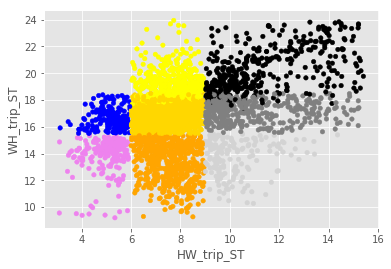

In [13]:
trips_sim.plot.scatter(x='HW_trip_ST',
                       y='WH_trip_ST',
                       c=trips_sim.TOD.apply(lambda x: colors[x]))